## Assignment 3 - Implicit Numerical Solvers

In [74]:
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt

import importlib
import numerical_solvers
importlib.reload(numerical_solvers)
from numerical_solvers import *

In [63]:
plt.rcParams.update({'text.usetex': True,
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'axes.unicode_minus': False,
                     'font.size': 12}) 

#### Problem 1 - Newton Solver

In [51]:
time = sm.symbols("t")
x1, x2, x3 = sm.symbols("x_1 x_2 x_3")

state = sm.Matrix([x1, x2, x3])
f_sym = sm.Matrix([(x1 + 1)**3, (x2 + 1)**3, (x3 + 1)**3])
Jf_sym = f_sym.jacobian(state)

f = sm.lambdify([time, state], f_sym, "numpy")
Jf = sm.lambdify([time, state], Jf_sym, "numpy")

In [52]:
solution = newtons_method([0], [0, 0, 0], f, Jf)
print(solution)

[-0.99999897 -0.99999897 -0.99999897]


#### Problem 2 - Implicit Euler and Midpoint

In [59]:
omega = 1
t, x, v = sm.symbols("t, x, v")
state = sm.Matrix([x, v])
_f = sm.Matrix([v, -omega**2 * x])
_Jf = _f.jacobian(state)
f = sm.lambdify([t, state], _f, "numpy")
Jf = sm.lambdify([t, state], _Jf, "numpy")

In [60]:
def simulate_with_stepper(x0: np.ndarray, t0, tf, h, stepper, g, Jg):
    n = int((tf-t0)//h) + 1
    ts = np.array([i*h for i in range(n)])
    xs = np.zeros((2, n))
    xs[:, 0] = x0

    for i in range(1, n):
        xs[:, i] = stepper(ts[i-1], xs[:, i-1], h, g, Jg)
    
    return ts, xs

In [ ]:
# Simulation parameters
ics = (1, 0)
t0, tf = 0, 10
h = 0.01

ts_ie, xs_ie = simulate_with_stepper(np.array(ics), t0, tf, h, implicit_euler_step, f, Jf)
ts_im, xs_im = simulate_with_stepper(np.array(ics), t0, tf, h, implicit_midpoint_step, f, Jf)

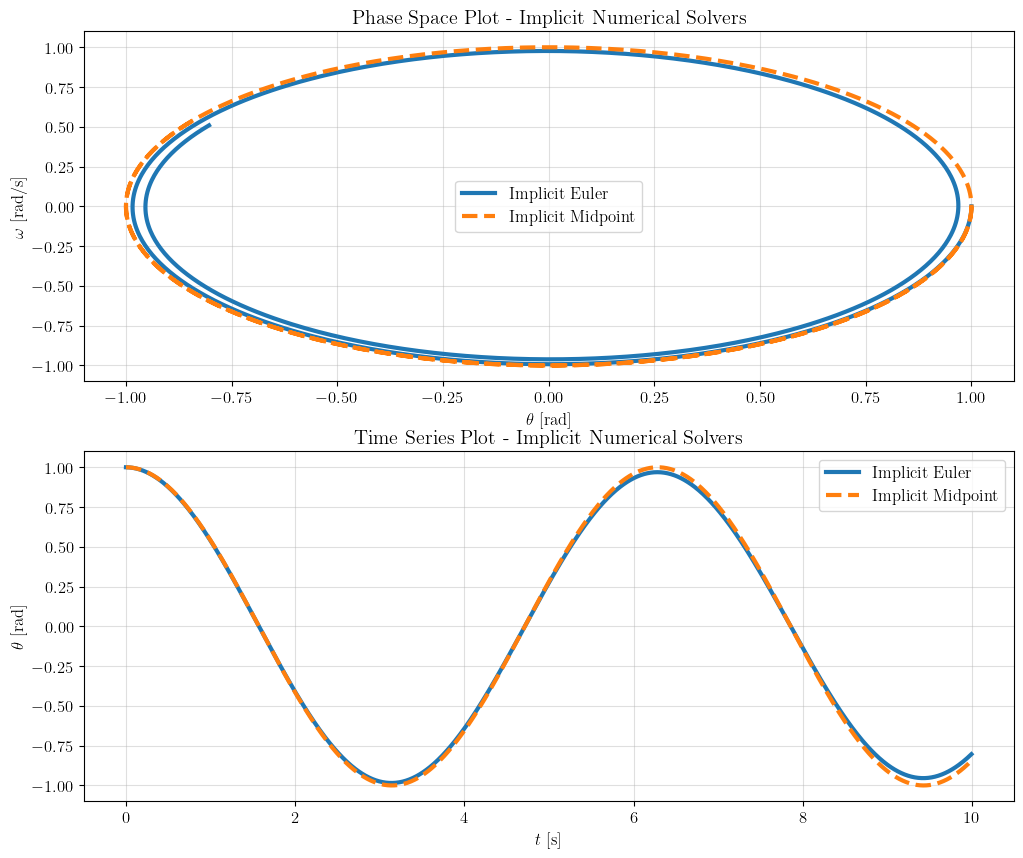

In [86]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(xs_ie[0, :], xs_ie[1, :], label="Implicit Euler", lw=3)
axs[0].plot(xs_im[0, :], xs_im[1, :], label="Implicit Midpoint", lw=3, ls="--")
axs[0].set_title("Phase Space Plot - Implicit Numerical Solvers")
axs[0].set_xlabel("$\\theta$ [rad]")
axs[0].set_ylabel("$\\omega$ [rad/s]")
axs[0].legend()
axs[0].grid(True, alpha=0.4)

axs[1].plot(ts_ie, xs_ie[0, :], label="Implicit Euler", lw=3)
axs[1].plot(ts_im, xs_im[0, :], label="Implicit Midpoint", lw=3, ls="--")
axs[1].set_title("Time Series Plot - Implicit Numerical Solvers")
axs[1].set_xlabel("$t$ [s]")
axs[1].set_ylabel("$\\theta$ [rad]")
axs[1].legend()
axs[1].grid(True, alpha=0.4)

plt.show()

In [89]:
def oscillator_solution(ts, omega):
    return np.array([np.cos(omega*ts), -omega*np.sin(omega*ts)])

ref_solution = oscillator_solution(ts_ie, omega)

In [88]:
def oscillator_energy(xs: np.ndarray, omega: float) -> np.ndarray:
    x = xs[0, :]
    v = xs[1, :]
    return 0.5 * v**2 + 0.5 * omega**2 * x**2

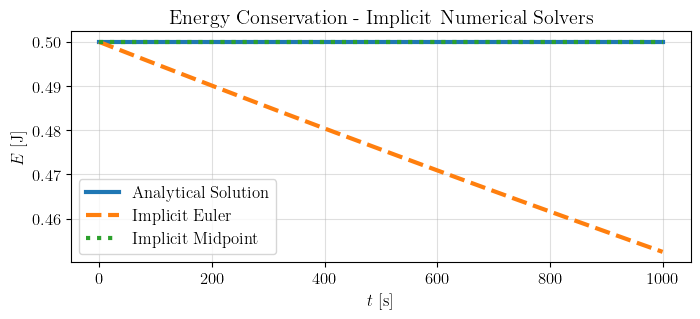

In [94]:
plt.figure(figsize=(8, 3))
plt.plot(oscillator_energy(ref_solution, omega), label="Analytical Solution", lw=3)
plt.plot(oscillator_energy(xs_ie, omega), label="Implicit Euler", lw=3, ls="--")
plt.plot(oscillator_energy(xs_im, omega), label="Implicit Midpoint", lw=3, ls=":")
plt.title("Energy Conservation - Implicit Numerical Solvers")
plt.xlabel("$t$ [s]")
plt.ylabel("$E$ [J]")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [95]:
def compute_error(my_sol, ref_sol, h):
    return np.sqrt(np.sum(h * np.linalg.norm(np.abs(ref_sol - my_sol), axis=0)**2))

def compute_eoc(errors, hs):
    eocs = [np.inf]
    for i in range(1, len(errors)):
        eocs.append(np.log(errors[i-1] / errors[i]) / np.log(hs[i-1] / hs[i]))
    return eocs

def compare_stepper(t0, tf, hs, stepper, ics):
    errors = []
    for h in hs:
        _ts, _sol = simulate_with_stepper(np.array(ics), t0, tf, h, stepper, f, Jf)
        _ref = oscillator_solution(_ts, omega)
        errors.append(compute_error(_sol, _ref, h))
    
    eocs = compute_eoc(errors, hs)

    return errors, eocs

In [96]:
err_ie, eoc_ie = compare_stepper(t0, 1, [.5, .25, .125, .0625], implicit_euler_step, ics)
err_im, eoc_im = compare_stepper(t0, 1, [.5, .25, .125, .0625], implicit_midpoint_step, ics)

          Impl. Euler  Impl. Midpoint
0.001000          inf             inf
0.000500     0.999323        1.999458
0.000250     0.999662        1.999729
0.000125     0.999831        1.999866
0.000063     0.999915        1.999944


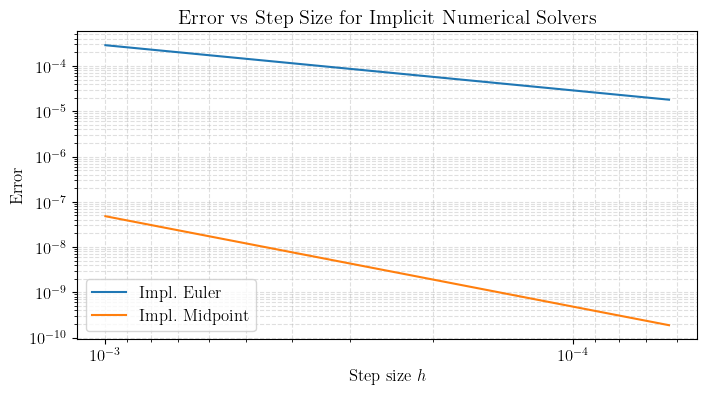

In [102]:
import pandas as pd

names = ["Impl. Euler", "Impl. Midpoint"]
steppers = [implicit_euler_step, implicit_midpoint_step]
hs = [.001 / 2**i for i in range(5)]
eoc_df = pd.DataFrame(index=hs)

plt.figure(figsize=(8, 4))
for name, stepper in zip (names, steppers):
    _errs, _eocs = compare_stepper(t0, 1, hs, stepper, ics)
    plt.loglog(hs, _errs, label=name)
    eoc_df[name] = _eocs

print(eoc_df)
plt.gca().invert_xaxis()
plt.title("Error vs Step Size for Implicit Numerical Solvers")
plt.xlabel("Step size $h$")
plt.ylabel("Error")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()